## 실습환경 구성
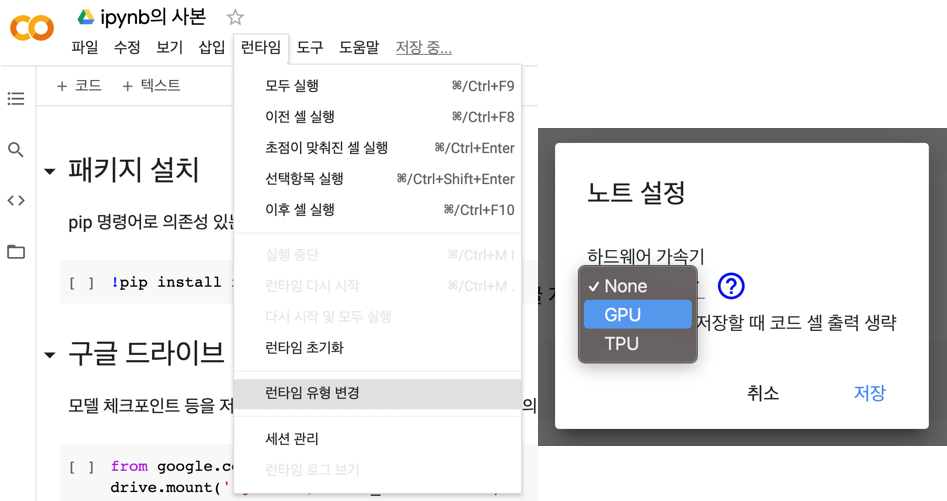

코랩 세션 유지
```javascript
function ClickConnect() {
    var buttons = document.querySelectorAll("colab-dialog.yes-no-dialog paper-button#cancel"); 
    buttons.forEach(function(btn) { 
        btn.click(); 
    }); 
    console.log("1분마다 자동 재연결"); 
    document.querySelector("colab-toolbar-button#connect").click(); 
} 
setInterval(ClickConnect,1000*60);
```

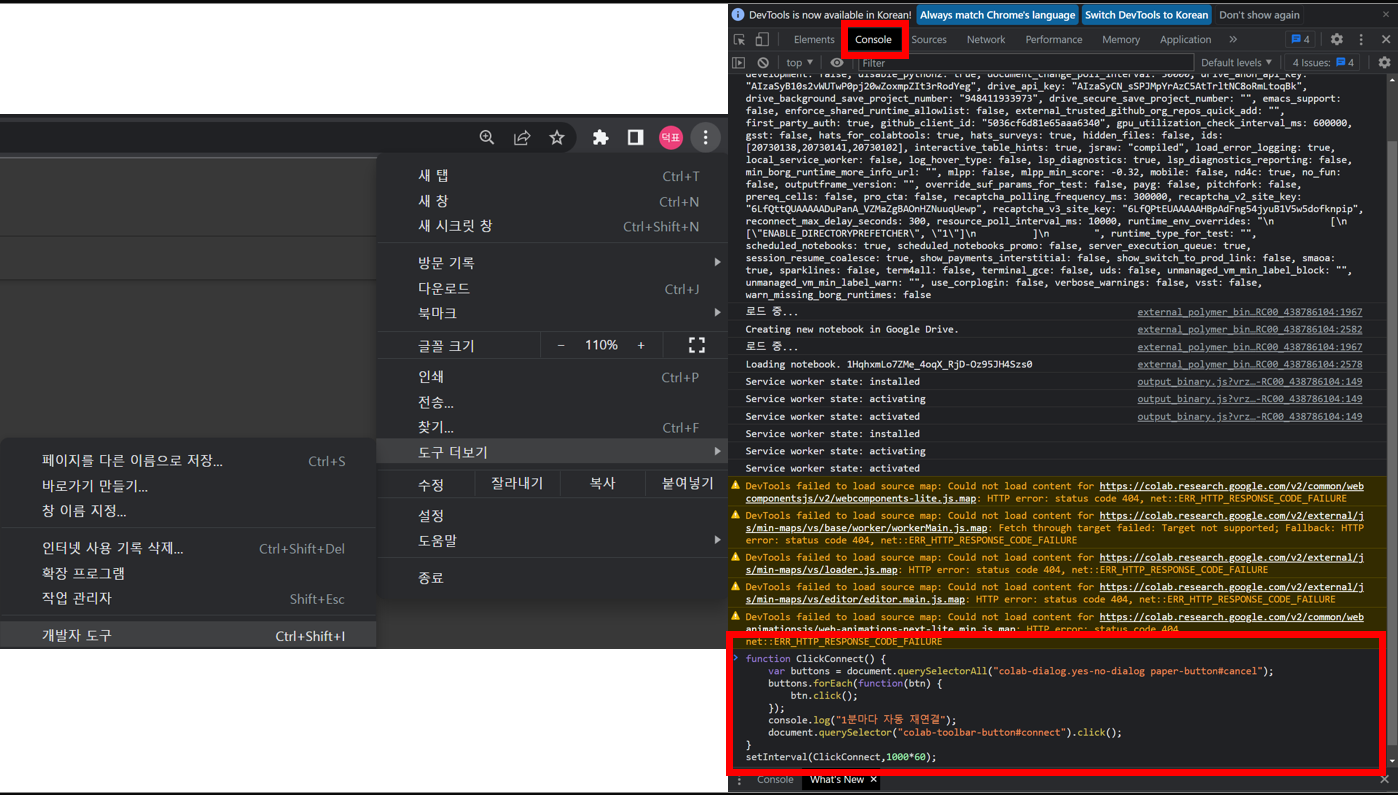

# DeepSpeech2

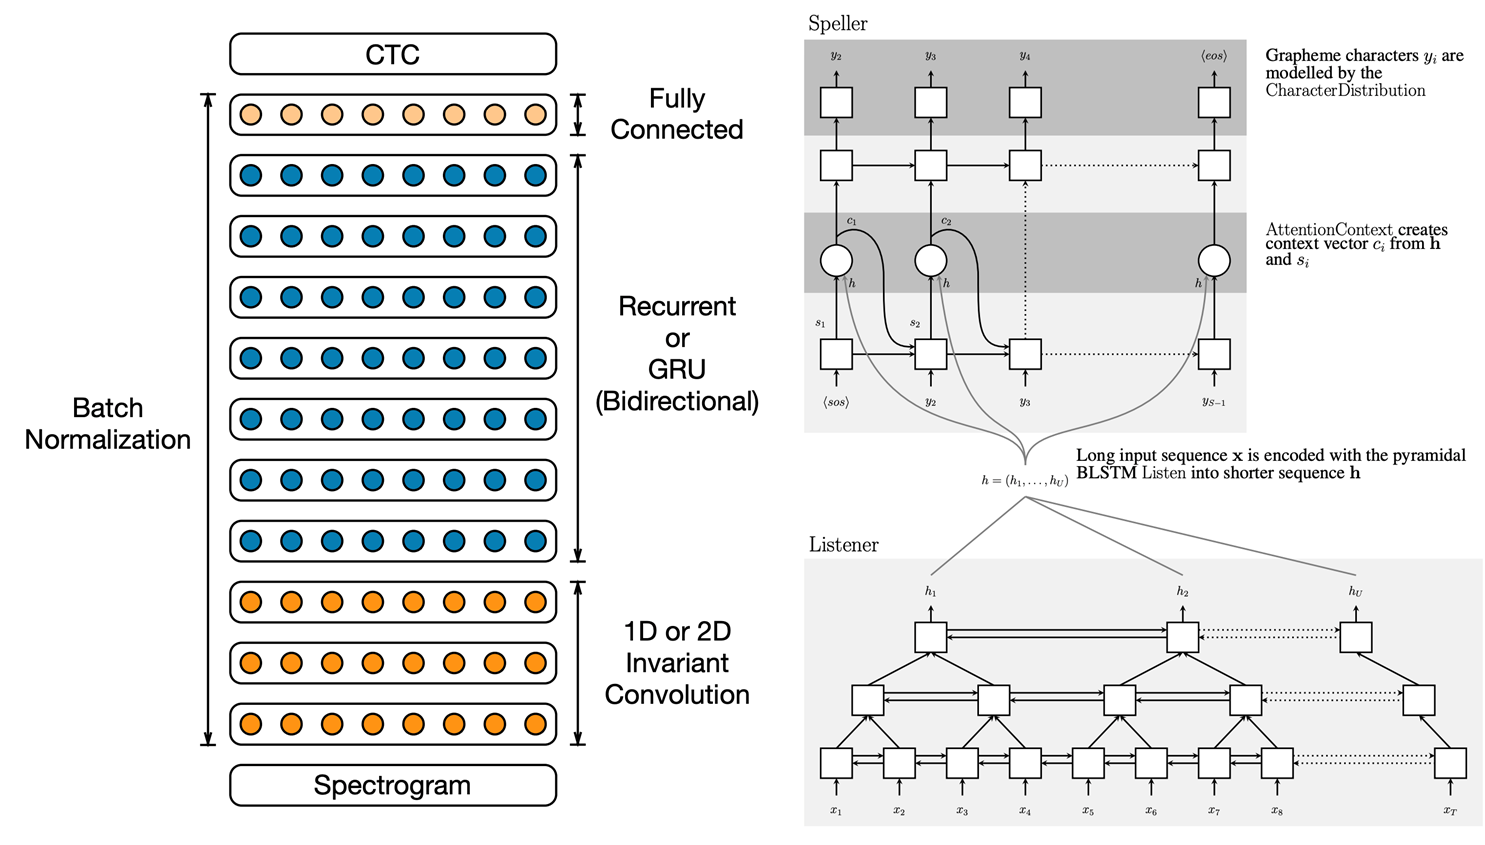

# Connectionist Temporal Classification(CTC)
-일반적인 음성인식(Speech Recongition)에서 우리는 데이터셋으로 오디오 클립과, Transcript를 받는다.
- 하지만 우리는 어떤 단어의 Character가 Audio와 Alignment가 맞지 않는다.
- Alignment 없이, 어떤 Audio와 Text 사이의 규칙을 정의할 수 없다.
- 또한, 사람이나 지역 마다 언어사용을 하는것은 다양하기 떄문에 단일한 규칙을 정의할 수 없다.
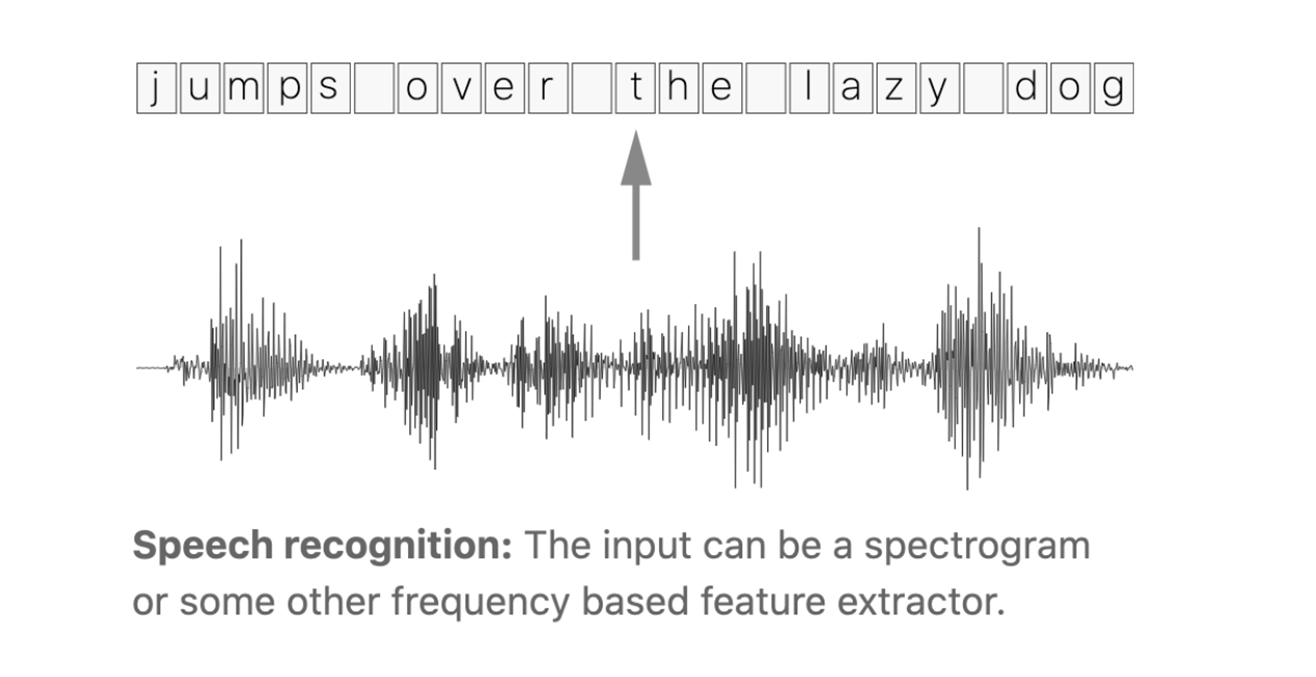

- 우리가 input과 output사이의 정확한 정렬(Alignment)이 labeling되어있는 데이터셋이 까지는 아니더라도, 주어진 input에 대해서 output의 확률값은 필요.
- CTC는 둘 사이의 가능한 모든 alignment의 가능성을 합산하여 작용(CTC works by summing over the probability of all possible alignments between the two).
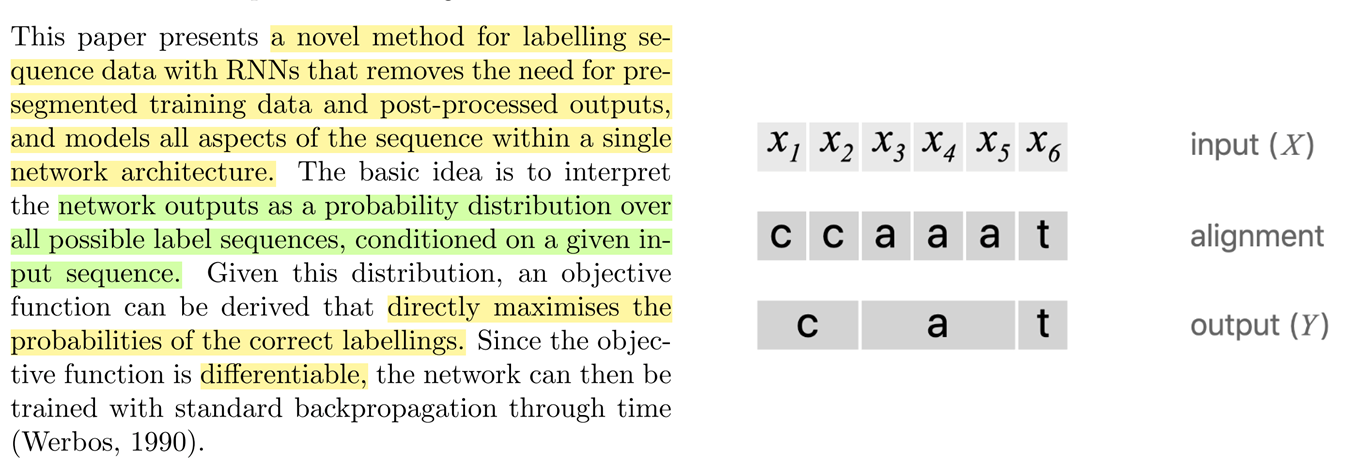

- 이러한 접근법은 2가지 문제:   
    > - 띄어쓰기 또는 묵음이 존재하는 부분 또한 글자가 할당되는 문제가 발생.
    
    - 이러한 문제를 해결하기 위해서 CTC는 허용된 output에 새로운 토큰(epsilon)을 도입   
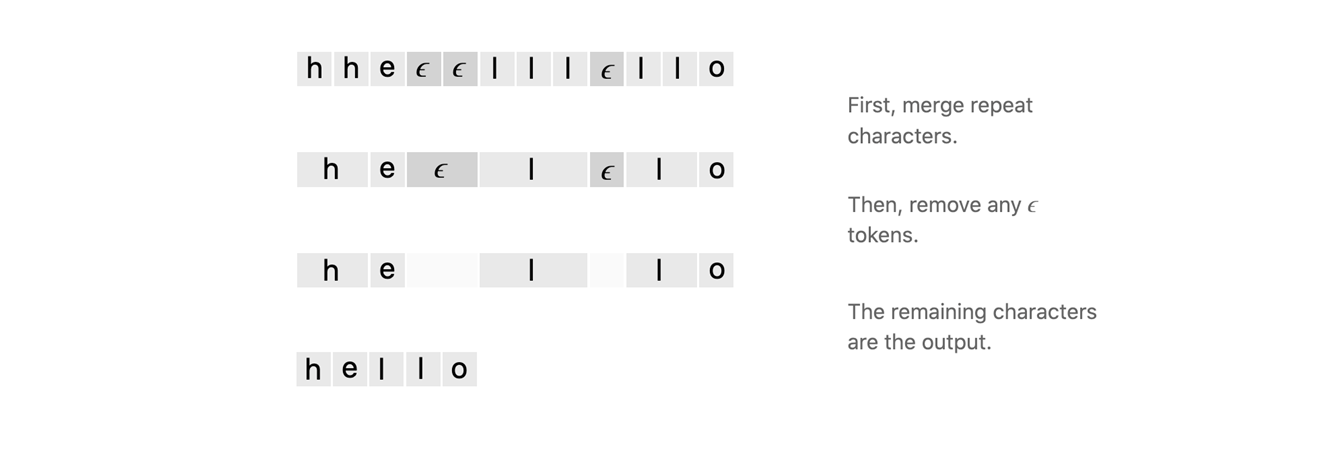
    

- CTC Alignmnet에는 속성
    - 하나의 Input에서 next input으로 진행하면서 output을 동일하게 유지하거나 next output으로 할당
    - 순서가 중요하다.
    - many-to-one 함수: 하나 이상의 input이 output에 들어갈 수 있지만 그 반대는 안된다.   
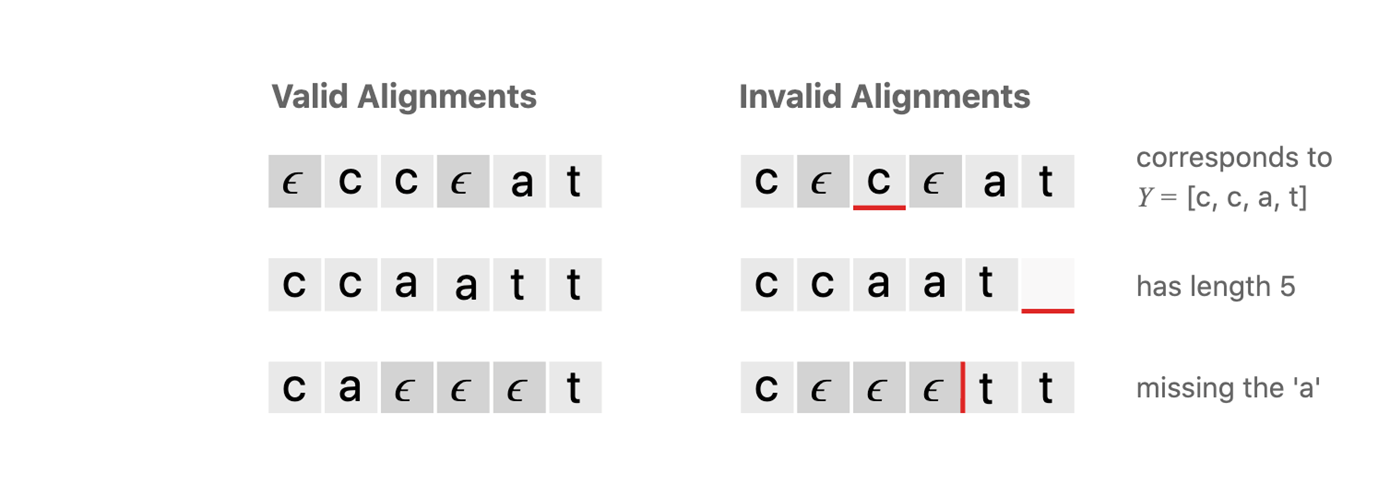


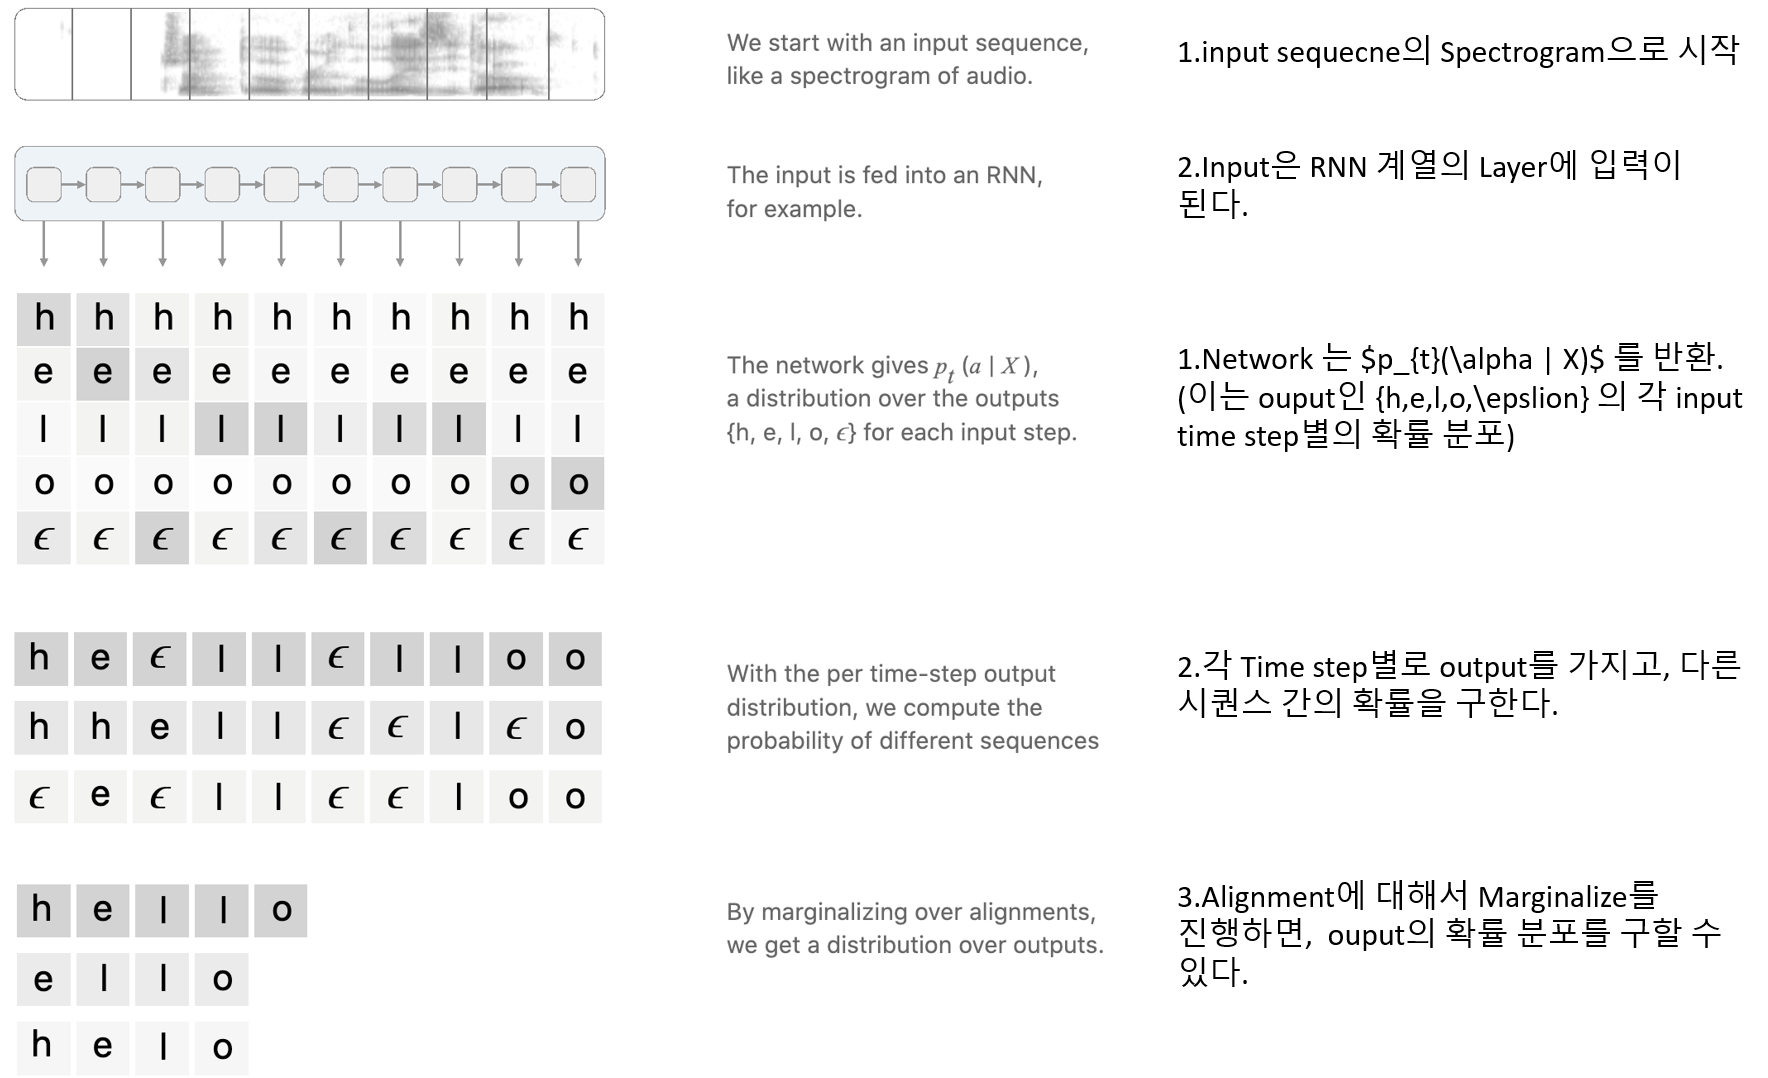

In [ ]:
!pip install torch
!pip install torchaudio


### Reference 

- Digital Signal Processing Lecturehttps://github.com/spatialaudio/digital-signal-processing-lecture 

- Python for Signal Processing (unipingco)https://github.com/unpingco/Python-for-Signal-Processing 

- Audio for Deep Learning (남기현님)https://tykimos.github.io/2019/07/04/ISS_2nd_Deep_Learning_Conference_All_Together/ 

- 오디오 전처리 작업을 위한 연습 (박수철님)https://github.com/scpark20/audio-preprocessing-practice 

- Musical Applications of Machine Learninghttps://mac.kaist.ac.kr/~juhan/gct634/ 

- Awesome audio study materials for Korean (최근우님)https://github.com/keunwoochoi/awesome-audio-study-materials-for-korean

In [ ]:
import os
import torch
import torch.nn as nn
import torch.utils.data as data
import torch.optim as optim
import torch.nn.functional as F
import torchaudio
import numpy as np

In [ ]:
train_dataset = torchaudio.datasets.LIBRISPEECH("./", url="train-clean-100", download=True) 
test_dataset = torchaudio.datasets.LIBRISPEECH("./", url="test-clean", download=True)

  0%|          | 0.00/5.95G [00:00<?, ?B/s]

  0%|          | 0.00/331M [00:00<?, ?B/s]

In [ ]:
test_dataset[10]
#소리 데이터, 샘플레이트 

(tensor([[-0.0004, -0.0003, -0.0004,  ..., -0.0010, -0.0012, -0.0011]]),
 16000,
 'WELL NOW ENNIS I DECLARE YOU HAVE A HEAD AND SO HAS MY STICK',
 1089,
 134686,
 10)

In [ ]:
def avg_wer(wer_scores, combined_ref_len):
    return float(sum(wer_scores)) / float(combined_ref_len)

def _levenshtein_distance(ref, hyp):
    """"Levenshtein distance"는 두 시퀀스 간의 차이를 측정하기위한 문자열 메트릭입니다. 
    "Levenshtein distance"는 한 단어를 다른 단어로 변경하는 데 필요한 최소 한 문자 편집 (대체, 삽입 또는 삭제) 수로 정의됩니다. 
    """
    m = len(ref)
    n = len(hyp)

    # special case
    if ref == hyp:
        return 0
    if m == 0:
        return n
    if n == 0:
        return m

    if m < n:
        ref, hyp = hyp, ref
        m, n = n, m

    # use O(min(m, n)) space
    distance = np.zeros((2, n + 1), dtype=np.int32)

    # initialize distance matrix
    for j in range(0,n + 1):
        distance[0][j] = j

    # calculate levenshtein distance
    for i in range(1, m + 1):
        prev_row_idx = (i - 1) % 2
        cur_row_idx = i % 2
        distance[cur_row_idx][0] = i
        for j in range(1, n + 1):
            if ref[i - 1] == hyp[j - 1]:
                distance[cur_row_idx][j] = distance[prev_row_idx][j - 1]
            else:
                s_num = distance[prev_row_idx][j - 1] + 1
                i_num = distance[cur_row_idx][j - 1] + 1
                d_num = distance[prev_row_idx][j] + 1
                distance[cur_row_idx][j] = min(s_num, i_num, d_num)

    return distance[m % 2][n]


In [ ]:
def word_errors(reference, hypothesis, ignore_case=False, delimiter=' '):
    """참조 시퀀스와 가설 시퀀스 사이의 거리를 단어 수준으로 계산합니다.
     : param reference : 참조 문장.
     : param hypothesis : 가설 문장.
     : param ignore_case : 대소 문자 구분 여부.
     : param delimiter : 입력 문장의 구분자.
    """
    if ignore_case == True:
        reference = reference.lower()
        hypothesis = hypothesis.lower()

    ref_words = reference.split(delimiter)
    hyp_words = hypothesis.split(delimiter)

    edit_distance = _levenshtein_distance(ref_words, hyp_words)
    return float(edit_distance), len(ref_words)

In [ ]:
def char_errors(reference, hypothesis, ignore_case=False, remove_space=False):
    if ignore_case == True:
        reference = reference.lower()
        hypothesis = hypothesis.lower()

    join_char = ' '
    if remove_space == True:
        join_char = ''

    reference = join_char.join(filter(None, reference.split(' ')))
    hypothesis = join_char.join(filter(None, hypothesis.split(' ')))

    edit_distance = _levenshtein_distance(reference, hypothesis)
    return float(edit_distance), len(reference)

In [ ]:
def wer(reference, hypothesis, ignore_case=False, delimiter=' '):
    """Calculate word error rate (WER). 
    WER = (Sw + Dw + Iw) / Nw
    Sw는 대체 된 단어의 수입니다.
    Dw는 삭제 된 단어의 수입니다.
    Iw는 삽입 된 단어의 수입니다.
    Nw는 참조의 단어 수입니다.
    """
    edit_distance, ref_len = word_errors(reference, hypothesis, ignore_case,
                                         delimiter)
    if ref_len == 0:
        raise ValueError("Reference's word number should be greater than 0.")

    wer = float(edit_distance) / ref_len
    return wer

In [ ]:
def cer(reference, hypothesis, ignore_case=False, remove_space=False):
    """Calculate charactor error rate (CER). 
        CER = (Sc + Dc + Ic) / Nc
        Sc is the number of characters substituted,
        Dc is the number of characters deleted,
        Ic is the number of characters inserted
        Nc is the number of characters in the reference
    """
    edit_distance, ref_len = char_errors(reference, hypothesis, ignore_case,
                                         remove_space)

    if ref_len == 0:
        raise ValueError("Length of reference should be greater than 0.")

    cer = float(edit_distance) / ref_len
    return cer

The outputs of the network are the graphemes of each language. At each output time-step t, the RNN
makes a prediction over characters, p(`t|x), where `t is either a character in the alphabet or the blank
symbol. In English we have `t ∈ {a, b, c, . . . , z,space, apostrophe, blank},

In [ ]:
class TextTransform:
    """Maps characters to integers and vice versa"""
    def __init__(self):
        char_map_str = """
        ' 0
        <SPACE> 1
        a 2
        b 3
        c 4
        d 5
        e 6
        f 7
        g 8
        h 9
        i 10
        j 11
        k 12
        l 13
        m 14
        n 15
        o 16
        p 17
        q 18
        r 19
        s 20
        t 21
        u 22
        v 23
        w 24
        x 25
        y 26
        z 27
        """
        self.char_map = {}
        self.index_map = {}
        for line in char_map_str.strip().split('\n'):
            ch, index = line.split()
            self.char_map[ch] = int(index)
            self.index_map[int(index)] = ch
        self.index_map[1] = ' '

    def text_to_int(self, text):
        """ Use a character map and convert text to an integer sequence """
        int_sequence = []
        for c in text:
            if c == ' ':
                ch = self.char_map['<SPACE>']
            else:
                ch = self.char_map[c]
            int_sequence.append(ch)
        return int_sequence

    def int_to_text(self, labels):
        """ Use a character map and convert integer labels to an text sequence """
        string = []
        for i in labels:
            string.append(self.index_map[i])
        return ''.join(string).replace('<SPACE>', ' ')

In [ ]:
train_audio_transforms = nn.Sequential(
    torchaudio.transforms.MelSpectrogram(sample_rate=16000, n_mels=128),
    torchaudio.transforms.FrequencyMasking(freq_mask_param=30),
    torchaudio.transforms.TimeMasking(time_mask_param=100)
)

valid_audio_transforms = torchaudio.transforms.MelSpectrogram()

text_transform = TextTransform()

/usr/local/lib/python3.7/dist-packages/torchaudio/functional/functional.py:595: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (128) may be set too high. Or, the value for `n_freqs` (201) may be set too low.
  "At least one mel filterbank has all zero values. "


In [ ]:
def data_processing(data, data_type="train"):
    spectrograms = []
    labels = []
    input_lengths = []
    label_lengths = []
    for (waveform, _, utterance, _, _, _) in data:
        if data_type == 'train':
            spec = train_audio_transforms(waveform).squeeze(0).transpose(0, 1)
        elif data_type == 'valid':
            spec = valid_audio_transforms(waveform).squeeze(0).transpose(0, 1)
        else:
            raise Exception('data_type should be train or valid')
        spectrograms.append(spec)
        label = torch.Tensor(text_transform.text_to_int(utterance.lower()))
        labels.append(label)
        input_lengths.append(spec.shape[0]//2)
        label_lengths.append(len(label))

    spectrograms = nn.utils.rnn.pad_sequence(spectrograms, batch_first=True).unsqueeze(1).transpose(2, 3)
    labels = nn.utils.rnn.pad_sequence(labels, batch_first=True)

    return spectrograms, labels, input_lengths, label_lengths


In both cases we integrate a language model in a beam search decoding step

In [ ]:
def GreedyDecoder(output, labels, label_lengths, blank_label=28, collapse_repeated=True):
	arg_maxes = torch.argmax(output, dim=2)
	decodes = []
	targets = []
	for i, args in enumerate(arg_maxes):
		decode = []
		targets.append(text_transform.int_to_text(labels[i][:label_lengths[i]].tolist()))
		for j, index in enumerate(args):
			if index != blank_label:
				if collapse_repeated and j != 0 and index == args[j -1]:
					continue
				decode.append(index.item())
		decodes.append(text_transform.int_to_text(decode))
	return decodes, targets

We use the clipped rectifiedlinear (ReLU) function σ(x) = min{max{x, 0}, 20} as our nonlinearity.

The architectures we experiment
with consist of one or more convolutional layers, followed by one or more recurrent layers, followed
by one or more fully connected layers.
The hidden representation at layer l is given by h
l with the convention that h
0
represents the input
x. The bottom of the network is one or more convolutions over the time dimension of the input

In [ ]:
class CNNLayerNorm(nn.Module):
    """Layer normalization built for cnns input"""
    def __init__(self, n_feats):
        super(CNNLayerNorm, self).__init__()
        self.layer_norm = nn.LayerNorm(n_feats)

    def forward(self, x):
        # x (batch, channel, feature, time)
        x = x.transpose(2, 3).contiguous() # (batch, channel, time, feature)
        x = self.layer_norm(x)
        return x.transpose(2, 3).contiguous() # (batch, channel, feature, time) 


In [ ]:
class ResidualCNN(nn.Module):
    def __init__(self, in_channels, out_channels, kernel, stride, dropout, n_feats):
        super(ResidualCNN, self).__init__()

        self.cnn1 = nn.Conv2d(in_channels, out_channels, kernel, stride, padding=kernel//2)
        self.cnn2 = nn.Conv2d(out_channels, out_channels, kernel, stride, padding=kernel//2)
        self.dropout1 = nn.Dropout(dropout)
        self.dropout2 = nn.Dropout(dropout)
        self.layer_norm1 = CNNLayerNorm(n_feats)
        self.layer_norm2 = CNNLayerNorm(n_feats)

    def forward(self, x):
        residual = x  # (batch, channel, feature, time)
        x = self.layer_norm1(x)
        x = F.gelu(x)
        x = self.dropout1(x)
        x = self.cnn1(x)
        x = self.layer_norm2(x)
        x = F.gelu(x)
        x = self.dropout2(x)
        x = self.cnn2(x)
        x += residual
        return x # (batch, channel, feature, time)

In [ ]:
# The two sets of activations are summed to form the output activations for the layer h The function g(·) can be the standard recurrent operation
class BidirectionalGRU(nn.Module):
    def __init__(self, rnn_dim, hidden_size, dropout, batch_first):
        super(BidirectionalGRU, self).__init__()

        self.BiGRU = nn.GRU(
            input_size=rnn_dim, hidden_size=hidden_size,
            num_layers=1, batch_first=batch_first, bidirectional=True)
        self.layer_norm = nn.LayerNorm(rnn_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        x = self.layer_norm(x)
        x = F.gelu(x)
        x, _ = self.BiGRU(x)
        x = self.dropout(x)
        return x

In [ ]:
class SpeechRecognitionModel(nn.Module):
    def __init__(self, n_cnn_layers, n_rnn_layers, rnn_dim, n_class, n_feats, stride=2, dropout=0.1):
        super(SpeechRecognitionModel, self).__init__()
        n_feats = n_feats//2
        self.cnn = nn.Conv2d(1, 32, 3, stride=stride, padding=3//2)  # cnn for extracting heirachal features

        # n residual cnn layers with filter size of 32
        self.rescnn_layers = nn.Sequential(*[
            ResidualCNN(32, 32, kernel=3, stride=1, dropout=dropout, n_feats=n_feats) 
            for _ in range(n_cnn_layers)
        ])
        self.fully_connected = nn.Linear(n_feats*32, rnn_dim)
        self.birnn_layers = nn.Sequential(*[
            BidirectionalGRU(rnn_dim=rnn_dim if i==0 else rnn_dim*2,
                             hidden_size=rnn_dim, dropout=dropout, batch_first=i==0)
            for i in range(n_rnn_layers)
        ])
        self.classifier = nn.Sequential(
            nn.Linear(rnn_dim*2, rnn_dim),  # birnn returns rnn_dim*2
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(rnn_dim, n_class)
        )

    def forward(self, x):
        x = self.cnn(x)
        x = self.rescnn_layers(x)
        sizes = x.size()
        x = x.view(sizes[0], sizes[1] * sizes[2], sizes[3])  # (batch, feature, time)
        x = x.transpose(1, 2) # (batch, time, feature)
        x = self.fully_connected(x)
        x = self.birnn_layers(x)
        x = self.classifier(x)
        return x

In [ ]:
import os
import numpy as np
from torch.utils.data import Dataset, DataLoader

class Dataset(Dataset):
    def __init__(self, x):
        self.x = x

    def __getitem__(self, index):
        return self.x[index]

    def __len__(self):
        return self.x.shape[0]

def load_dataset(data, data_type="train"):
    spectrograms = []
    labels = []
    input_lengths = []
    label_lengths = []
    for (waveform, _, _, _, _, _) in data:
        if data_type == 'train':
            spec = train_audio_transforms(waveform).squeeze(0).transpose(0, 1)
        else:
            spec = valid_audio_transforms(waveform).squeeze(0).transpose(0, 1)
        spectrograms.append(spec)
        
    return spectrograms

def get_dataloader(data):
    x_train = load_dataset(data, "train")
    x_valid = load_dataset(data, 'valid')

    mean = np.mean(x_train)
    std = np.std(x_train)
    x_train = (x_train - mean)/std
    x_valid = (x_valid - mean)/std

    train_set = Dataset(x_train)
    vaild_set = Dataset(x_valid)

    train_loader = DataLoader(train_set, batch_size=4, shuffle=True, drop_last=False)
    valid_loader = DataLoader(vaild_set, batch_size=4, shuffle=False, drop_last=False)
    
    return train_loader, valid_loader

이 튜토리얼에서는 "greedy"디코딩 방법을 사용하여 모델의 출력을 문자로 결합하여 대화 내용을 만들 수 있습니다. "greedy"디코더는 모델의 소프트 맥스 확률 문자 인 모델 출력을 취하며 각 시간 단계에 대해 가장 높은 확률을 가진 레이블을 선택합니다. 라벨이 빈 라벨 인 경우 최종 성적표에서 라벨이 제거됩니다.

In [ ]:
class IterMeter(object):
    """keeps track of total iterations"""
    def __init__(self):
        self.val = 0

    def step(self):
        self.val += 1

    def get(self):
        return self.val


def train(model, device, train_loader, criterion, optimizer, epoch, iter_meter):
    model.train()
    data_len = len(train_loader.dataset)
    for batch_idx, _data in enumerate(train_loader):
        spectrograms, labels, input_lengths, label_lengths = _data 
        spectrograms, labels = spectrograms.to(device), labels.to(device)

        optimizer.zero_grad()

        output = model(spectrograms)  # (batch, time, n_class)
        output = F.log_softmax(output, dim=2)
        output = output.transpose(0, 1) # (time, batch, n_class)

        loss = criterion(output, labels, input_lengths, label_lengths)
        loss.backward()

        optimizer.step()
        iter_meter.step()
        if batch_idx % 100 == 0 or batch_idx == data_len:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(spectrograms), data_len,
                100. * batch_idx / len(train_loader), loss.item()))


def test(model, device, test_loader, criterion, epoch, iter_meter):
    print('\nevaluating...')
    model.eval()
    test_loss = 0
    test_cer, test_wer = [], []
    with torch.no_grad():
        for i, _data in enumerate(test_loader):
            spectrograms, labels, input_lengths, label_lengths = _data 
            spectrograms, labels = spectrograms.to(device), labels.to(device)

            output = model(spectrograms)  # (batch, time, n_class)
            # The output layer L is a softmax computing a probability distribution over characters given
            output = F.log_softmax(output, dim=2)
            output = output.transpose(0, 1) # (time, batch, n_class)

            loss = criterion(output, labels, input_lengths, label_lengths)
            test_loss += loss.item() / len(test_loader)

            decoded_preds, decoded_targets = GreedyDecoder(output.transpose(0, 1), labels, label_lengths)
            for j in range(len(decoded_preds)):
                test_cer.append(cer(decoded_targets[j], decoded_preds[j]))
                test_wer.append(wer(decoded_targets[j], decoded_preds[j]))


    avg_cer = sum(test_cer)/len(test_cer)
    avg_wer = sum(test_wer)/len(test_wer)
    
    print('Test set: Average loss: {:.4f}, Average CER: {:4f} Average WER: {:.4f}\n'.format(test_loss, avg_cer, avg_wer))


def main(learning_rate=5e-4, batch_size=20, epochs=10,
        train_url="train-clean-100", test_url="test-clean"):

    hparams = {
        "n_cnn_layers": 3,
        "n_rnn_layers": 7,
        "rnn_dim": 512,
        "n_class": 29,
        "n_feats": 128,
        "stride":2,
        "dropout": 0.1,
        "learning_rate": learning_rate,
        "batch_size": batch_size,
        "epochs": epochs
    }


    use_cuda = torch.cuda.is_available()
    torch.manual_seed(7)
    device = torch.device("cuda" if use_cuda else "cpu")

    if not os.path.isdir("./data"):
        os.makedirs("./data")

    train_dataset = torchaudio.datasets.LIBRISPEECH("./data", url=train_url, download=True)
    test_dataset = torchaudio.datasets.LIBRISPEECH("./data", url=test_url, download=True)

    kwargs = {'num_workers': 1, 'pin_memory': True} if use_cuda else {}
    train_loader = data.DataLoader(dataset=train_dataset,
                                batch_size=hparams['batch_size'],
                                shuffle=True,
                                collate_fn=lambda x: data_processing(x, 'train'),
                                **kwargs)
    test_loader = data.DataLoader(dataset=test_dataset,
                                batch_size=hparams['batch_size'],
                                shuffle=False,
                                collate_fn=lambda x: data_processing(x, 'valid'),
                                **kwargs)

    model = SpeechRecognitionModel(
        hparams['n_cnn_layers'], hparams['n_rnn_layers'], hparams['rnn_dim'],
        hparams['n_class'], hparams['n_feats'], hparams['stride'], hparams['dropout']
        ).to(device)

    print('Num Model Parameters', sum([param.nelement() for param in model.parameters()]))

    optimizer = optim.Adam(model.parameters(), hparams['learning_rate'])
    criterion = nn.CTCLoss(blank=28).to(device)

    iter_meter = IterMeter()
    for epoch in range(1, epochs + 1):
        train(model, device, train_loader, criterion, optimizer, epoch, iter_meter)
        test(model, device, test_loader, criterion, epoch, iter_meter)


In [ ]:
learning_rate = 5e-4
batch_size = 1
epochs = 5
libri_train_set = "train-clean-100"
libri_test_set = "test-clean"

main(learning_rate, batch_size, epochs, libri_train_set, libri_test_set)

  0%|          | 0.00/5.95G [00:00<?, ?B/s]

  0%|          | 0.00/331M [00:00<?, ?B/s]

Num Model Parameters 33158941
Train Epoch: 1 [0/28539 (0%)]	Loss: 6.587040
Train Epoch: 1 [100/28539 (0%)]	Loss: 2.833716
Train Epoch: 1 [200/28539 (1%)]	Loss: 2.969005
Train Epoch: 1 [300/28539 (1%)]	Loss: 2.949261
Train Epoch: 1 [400/28539 (1%)]	Loss: 2.959582
Train Epoch: 1 [500/28539 (2%)]	Loss: 2.868870
Train Epoch: 1 [600/28539 (2%)]	Loss: 2.867179
Train Epoch: 1 [700/28539 (2%)]	Loss: 2.980225
Train Epoch: 1 [800/28539 (3%)]	Loss: 3.033880
Train Epoch: 1 [900/28539 (3%)]	Loss: 2.844609
Train Epoch: 1 [1000/28539 (4%)]	Loss: 2.827173
Train Epoch: 1 [1100/28539 (4%)]	Loss: 2.806144
Train Epoch: 1 [1200/28539 (4%)]	Loss: 3.018890
Train Epoch: 1 [1300/28539 (5%)]	Loss: 2.826139
Train Epoch: 1 [1400/28539 (5%)]	Loss: 2.978240
Train Epoch: 1 [1500/28539 (5%)]	Loss: 2.860535
Train Epoch: 1 [1600/28539 (6%)]	Loss: 2.890740
Train Epoch: 1 [1700/28539 (6%)]	Loss: 2.831832
Train Epoch: 1 [1800/28539 (6%)]	Loss: 2.879171
Train Epoch: 1 [1900/28539 (7%)]	Loss: 2.780260
Train Epoch: 1 [2000/2

KeyboardInterrupt: ignored